## Imports

In [1]:
"""Imports"""

import re
import json
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


## filter_res_by_cut_number

In [2]:
def filter_res_by_cut_number(cut_number, res_data):

    output = []
    for d in res_data:
        if d['number_of_cuts'] == cut_number:
            output.append(d)
    return output

## normalize_to_selected_frag_number

In [3]:
def normalize_to_selected_frag_number(res_data: list, properties_to_normalize: list[str], selected_frag_number: str, reciprocal: list[bool], keep_selected_frag_number: bool) -> list:

    # Initialize a dictionary to hold the sum of output values and count for each item
    item_outputs = {}

    # Loop through the dataset to group them based on sequence and cut number
    for d in res_data:
        key = (d["partition_search_method"], d["sequence"])
        if key not in set(item_outputs.keys()):
            item_outputs[key] = [d]
        if d not in item_outputs[key]:
            item_outputs[key].append(d)

    # Aggregate each group to one dict
    output = []
    for lst in item_outputs.values():
        for d in lst:
            out_d = d.copy()
            for property, reciprocal_ in zip(properties_to_normalize, reciprocal):
                property_of_each_frag_number = {d['number_of_fragments']: d[property] for d in lst}
                if property_of_each_frag_number[selected_frag_number] == 0:
                    normalized_value = float('nan')
                elif reciprocal_:
                    normalized_value = property_of_each_frag_number[selected_frag_number]/d[property]
                else:
                    normalized_value = d[property]/property_of_each_frag_number[selected_frag_number]
                out_d.update({f"{property}_normalized_to_{selected_frag_number}": normalized_value})
            output.append(out_d)

    if not keep_selected_frag_number:
        output = [d for d in output if d['number_of_fragments'] != selected_frag_number]

    return output


## normalize_to_selected_search_method

In [4]:
def normalize_to_selected_search_method(res_data: list, properties_to_normalize: list[str], selected_search_method: str, reciprocal: list[bool], keep_selected_search_method: bool) -> list:

    # Initialize a dictionary to hold the sum of output values and count for each item
    item_outputs = {}

    # Loop through the dataset to group them based on sequence and cut number
    for d in res_data:
        key = (d["number_of_cuts"], d["sequence"])
        if key not in set(item_outputs.keys()):
            item_outputs[key] = [d]
        if d not in item_outputs[key]:
            item_outputs[key].append(d)

    # Aggregate each group to one dict
    output = []
    for lst in item_outputs.values():
        for d in lst:
            out_d = d.copy()
            for property, reciprocal_ in zip(properties_to_normalize, reciprocal):
                property_of_each_method = {d['partition_search_method']: d[property] for d in lst}
                if property_of_each_method[selected_search_method] == 0:
                    normalized_value = float('nan')
                elif reciprocal_:
                    normalized_value = property_of_each_method[selected_search_method]/d[property]
                else:
                    normalized_value = d[property]/property_of_each_method[selected_search_method]
                out_d.update({f"{property}_normalized_to_{selected_search_method}": normalized_value})
            output.append(out_d)

    if not keep_selected_search_method:
        output = [d for d in output if d['partition_search_method'] != keep_selected_search_method]

    return output


## scattered_plot_cost

In [5]:
def scattered_plot_cost(x_axis, y_axis, yscale, y_lims, xscale, x_lims, group_param, res_data, cut_number_range, search_mode1, search_mode2, reg_order, title):

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16, 8))
    plt.subplots_adjust(wspace=0.5)
    fig.patch.set_facecolor('white')  # Set the background of the figure to white

    for ax, search_method in zip((ax1, ax2), [search_mode1, search_mode2]):

        df = pd.DataFrame([d for d in res_data if d['partition_search_method'] == search_method and d['number_of_cuts'] in cut_number_range])

        if not group_param:
            sns.regplot(data=df,
                        ax=ax,
                        x=x_axis,
                        y=y_axis,
                        scatter=True,
                        color=sns.color_palette("husl", 1)[0],
                        scatter_kws={'alpha':0.5,'s':20},
                        line_kws={'linewidth':1.5},
                        fit_reg=False)
        else:
            group_param_unique_items = set([d[group_param] for d in res_data])
            colors = sns.color_palette("husl", len(group_param_unique_items))
            color_map = {i:color for i, color in zip(group_param_unique_items, colors)}
            grouped = df.groupby(group_param)
            for key, group in grouped:
                sns.regplot(ax=ax,
                            x=group[x_axis],
                            y=group[y_axis],
                            scatter=True,
                            label=key,
                            color=color_map[key],
                            scatter_kws={'alpha':0.5,'s':30},
                            line_kws={'linewidth':1.5},
                            order=reg_order,
                            fit_reg=False)

        ax.set_ylabel(f"{str.title(re.sub('_', ' ', y_axis))} ([$], 0.1[$]/bp, log scale)")
        ax.set_xlabel(f"{str.title(re.sub('_', ' ', x_axis))} (log scale)")
        ax.legend(title=group_param, loc='upper left', ncols=2)
        ax.set_yscale(yscale)
        ax.set_ylim(y_lims[search_method])

        ticks = list(range(200, 1200, 200)) + \
                list(range(2000, 12000, 2000)) + \
                list(range(20000, 120000, 20000)) + \
                list(range(200000, 1200000, 200000)) + \
                list(range(2000000, 12000000, 2000000))

        labels = ticks
        ax.set_yticks(ticks=ticks, labels=labels)
        ax.set_xscale(xscale)
        ax.set_xlim(x_lims[search_method])
        ax.set_facecolor('white')  # Set the background of the axes to white
        ax.set_title(title)

    return plt

## Import and prepare data

In [6]:
"""Import and prepare data"""
from proseqteleporter.utils.utils import compute_lib_complexity

parent_dirs = [
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\characterization\results_from_SaS\rep0",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\characterization\results_from_SaS\input_complexity_cost_rep0_2-3f",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\characterization\input_complexity_cost_rep0_no_cut",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\characterization\results_from_SaS\rep1",]
res_data = []
count = 0
for parent_dir in parent_dirs:
    result_dirs = [d for d in listdir(parent_dir) if not isfile(join(parent_dir, d))]
    # print(result_dirs)

    for d in result_dirs:
        param_file = join(parent_dir, d, "results", "params_dist_mut_1.json")
        with open(param_file, 'r') as fp:
            param = json.load(fp)
        mutations_0idx = param['mutations_0idx']
        linked_mutations_0idx = param['linked_mutations_0idx']
        diversity = compute_lib_complexity(mutations=mutations_0idx, linked_mutations=linked_mutations_0idx)

        result_files = [join(parent_dir, d, "results", f)
                        for f in listdir(join(parent_dir, d, "results")) if re.search('\dfrags',f)]
        # print(result_files)

        for file_path in result_files:
            count +=1
            with open(file_path, 'r') as fp:
                res_per_cut = json.load(fp)

                res_dict_ = {}
                number_checked = res_per_cut["number_of_partitions_checked"]
                uq_number_checked = res_per_cut["num_of_checked_unique_partitions"]
                hard_constraint_violations = sum([v for v in res_per_cut["hard_constraint_violations"].values()])
                if len(res_per_cut["sel_partitions"]) > 0:
                    ligation_fidelity = res_per_cut["sel_partitions"][0]["ligation_fidelity"]
                    fragment_length_unevenness = res_per_cut["sel_partitions"][0]["fragment_length_unevenness"]
                    cost = res_per_cut["sel_partitions"][0]["cost"]
                else:
                    print(file_path)
                    print(res_per_cut["hard_constraint_violations"])
                    continue
                    # ligation_fidelity = fragment_length_unevenness = cost = float("nan")
                res_dict_.update({
                    'partition_search_method':"distribute mut and only keep the best",
                    'sequence':param['s'],
                    'complexity': diversity,
                    'seq_length':len(param["s"]),
                    'mutation_positions':len(mutations_0idx),
                    'mutation_variations':sum([len(mut['aa']) for mut in mutations_0idx]),
                    'number_of_cuts':res_per_cut['number_of_cuts'],
                    'number_of_fragments':res_per_cut['number_of_cuts']+1,
                    'elapsed_time':res_per_cut['elapsed_time']/60,
                    "ligation_fidelity":ligation_fidelity,
                    "fragment_length_unevenness":fragment_length_unevenness,
                    "cost":cost/0.06*0.1,
                    "base_count":cost/0.06,
                    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5204324/
                    "number_of_partitions_checked":number_checked,
                    "num_of_checked_unique_partitions":uq_number_checked,
                    "pass_constraint_percentage": (number_checked-hard_constraint_violations)/number_checked * 100
                                 })
                res_data.append(res_dict_)
                res_dict_cp_ = res_dict_.copy()
                # res_dict_cp_.update({"cost":cost/0.06*0.18})
                # res_data.append(res_dict_cp_)
print(count)



#
# res_data = normalize_to_selected_search_method(res_data=res_data,
#                                                properties_to_normalize=['elapsed_time'],
#                                                selected_search_method="exhaustive",
#                                                reciprocal=[True],
#                                                keep_selected_search_method=True)

# res_data = normalize_to_selected_frag_number(res_data=res_data,
#                                              properties_to_normalize=['cost'],
#                                              selected_frag_number='4',
#                                              reciprocal=[True],
#                                              keep_selected_frag_number=True)

C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\characterization\results_from_SaS\rep0\100nt_10000000000_2024-06-15output\results\dist_mut_1_2frags.json
{'Cost too high.': 4}
C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\characterization\results_from_SaS\rep0\100nt_10000000000_2024-06-15output\results\dist_mut_1_3frags.json
{'Cost too high.': 135}
C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\characterization\results_from_SaS\rep0\100nt_10000000_2024-06-15output\results\dist_mut_1_2frags.json
{'Cost too high.': 1}
C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\characterization\results_from_SaS\rep0\200nt_10000000000_2024-06-15output\results\dist_mut_1_2frags.json
{'Cost too high.': 3}
C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\characterization\results_from_SaS\rep0\200nt_10000000000_2024-06-15output\results\dist_mut_1_3frags.json
{'Cost too high.': 10}
C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\chara

In [7]:
df = pd.DataFrame([d for d in res_data if d['partition_search_method'] == "distribute mut and only keep the best"])
df

,partition_search_method,sequence,complexity,seq_length,mutation_positions,mutation_variations,number_of_cuts,number_of_fragments,elapsed_time,ligation_fidelity,fragment_length_unevenness,cost,base_count,number_of_partitions_checked,num_of_checked_unique_partitions,pass_constraint_percentage
0,distribute mut and only keep the best,YWYMTRGVCPGMPMGVAFLASKCDSMYIYFKRAKMNISGWTRWVDG...,10000000000,100,18,58,3,4,0.032333,1.00,0.750,44550.0,445500.0,108,108,100.000000
1,distribute mut and only keep the best,YWYMTRGVCPGMPMGVAFLASKCDSMYIYFKRAKMNISGWTRWVDG...,10000000000,100,18,58,4,5,0.682667,1.00,0.438,26550.0,265500.0,4860,4860,97.222222
2,distribute mut and only keep the best,EKIDQVWAEMNKYFLTGKTAQLWVKSESLVKPTPAKLCLPTRKYQA...,10000000,100,14,35,2,3,0.010833,1.00,4.917,40980.0,409800.0,2,2,100.000000
3,distribute mut and only keep the best,EKIDQVWAEMNKYFLTGKTAQLWVKSESLVKPTPAKLCLPTRKYQA...,10000000,100,14,35,3,4,0.019333,1.00,3.667,9330.0,93300.0,46,46,100.000000
4,distribute mut and only keep the best,EKIDQVWAEMNKYFLTGKTAQLWVKSESLVKPTPAKLCLPTRKYQA...,10000000,100,14,35,4,5,0.012500,0.99,4.143,3990.0,39900.0,6,6,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,distribute mut and only keep the best,GDFWFQPHGYEGGNHNNQTNTTGWFNGQCDINLVFNDENDWDPKTT...,10000000,500,14,35,4,5,36.695667,0.99,0.942,4980.6,49806.0,258720,258720,100.000000
200,distribute mut and only keep the best,CNTKEFVNIVFFLCQKKIVWYQTERPEYGEKCIAMPHRPAYHVPAA...,1000,500,6,15,1,2,0.019667,1.00,0.326,3868.5,38685.0,176,176,100.000000
201,distribute mut and only keep the best,CNTKEFVNIVFFLCQKKIVWYQTERPEYGEKCIAMPHRPAYHVPAA...,1000,500,6,15,2,3,1.652333,1.00,1.890,860.8,8608.0,22880,22880,100.000000
202,distribute mut and only keep the best,CNTKEFVNIVFFLCQKKIVWYQTERPEYGEKCIAMPHRPAYHVPAA...,1000,500,6,15,3,4,71.690833,1.00,6.108,835.3,8353.0,640640,640640,99.862950


## Plotting - Scatter Plots - cost
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5204324/

100
200
300
500


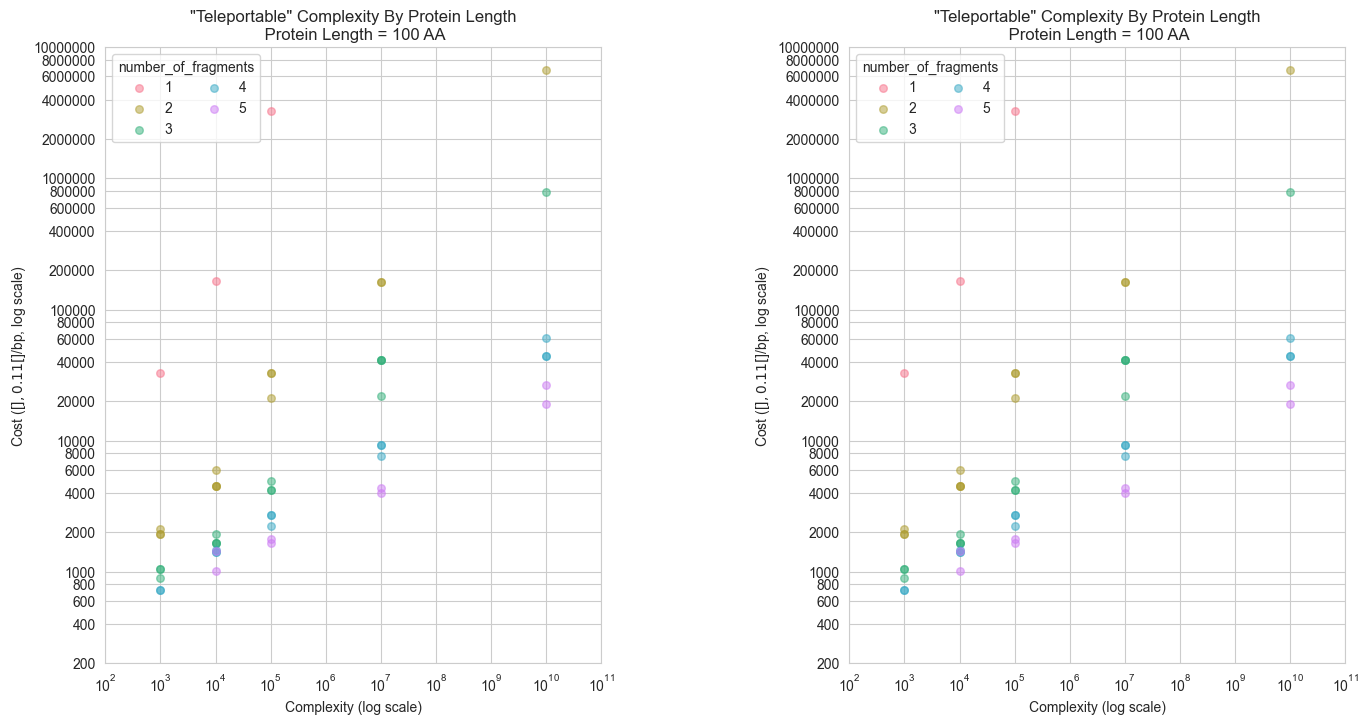

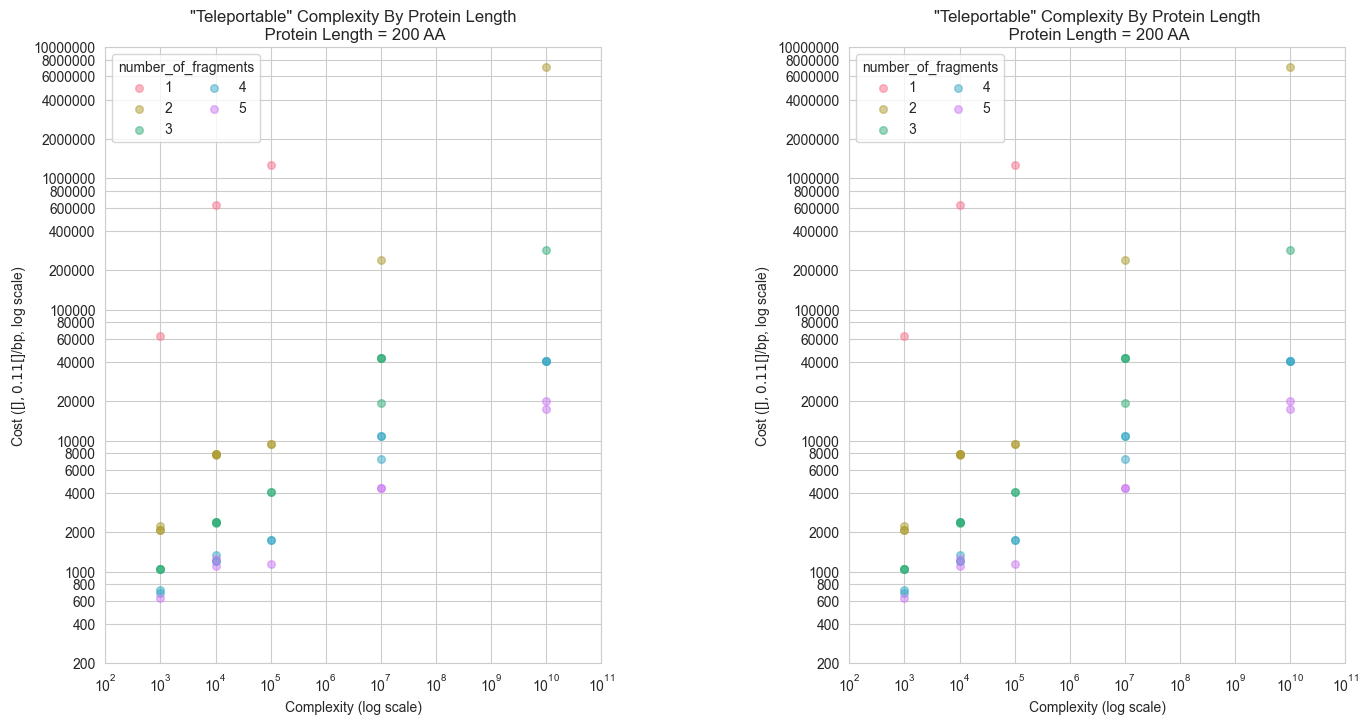

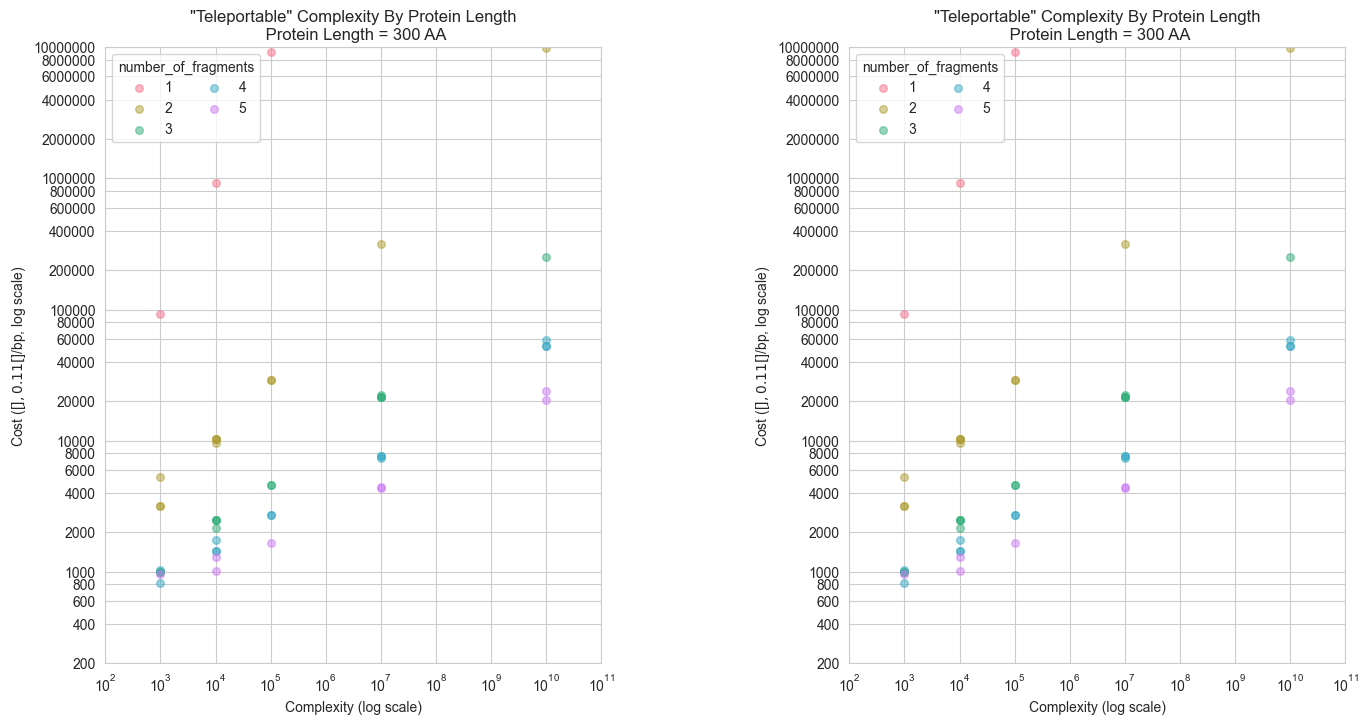

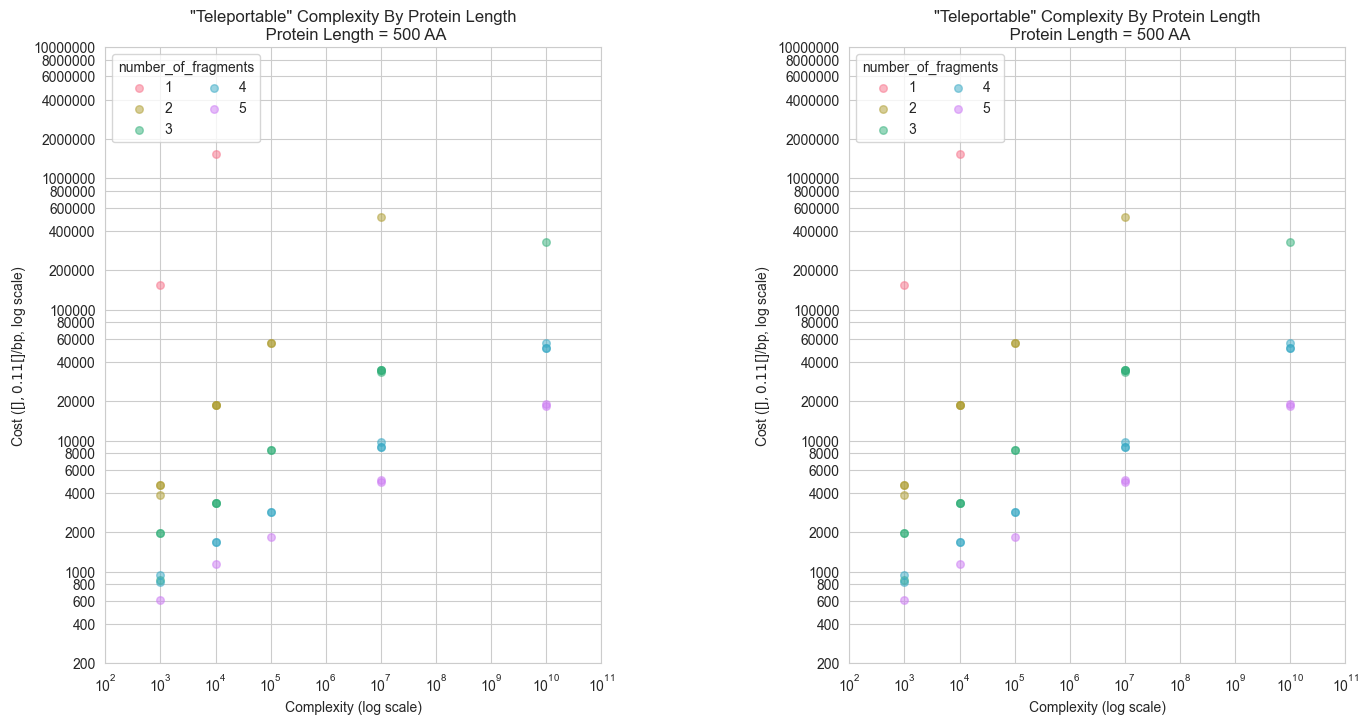

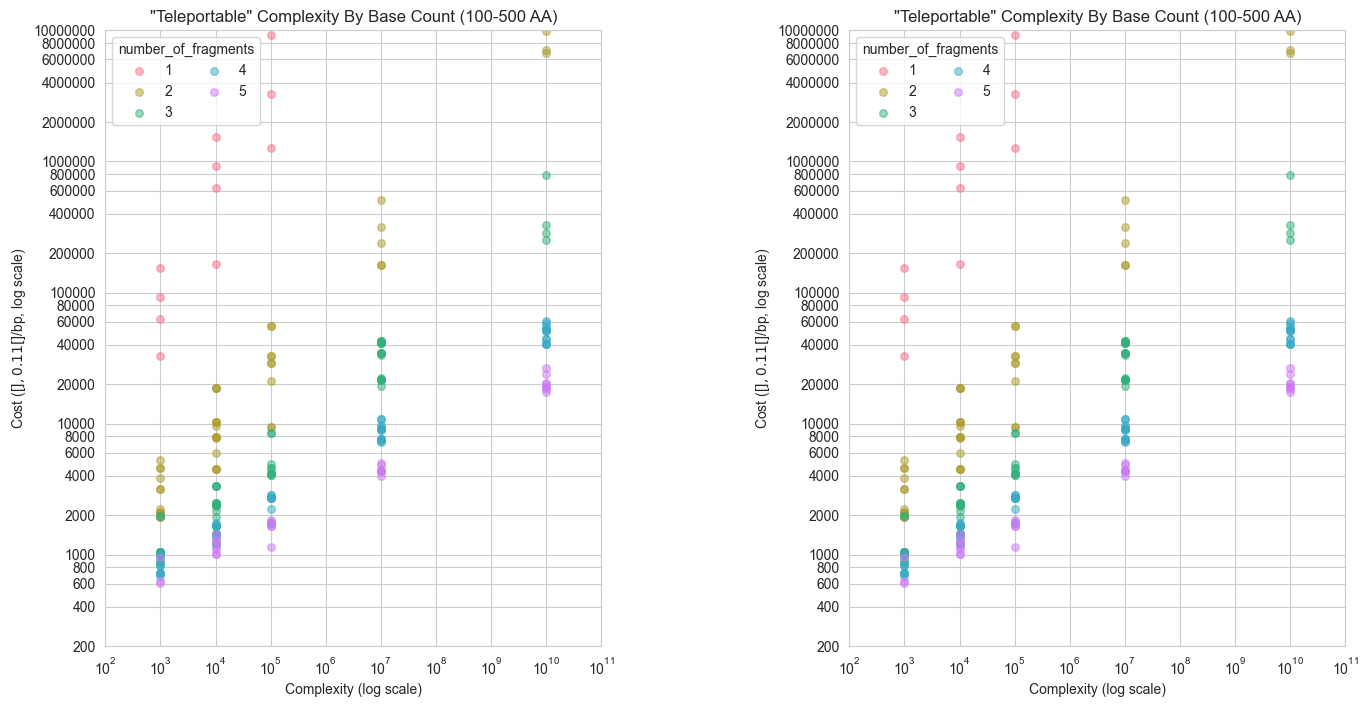

In [8]:
"""Plotting - Scatter Plots"""

search_mode1="distribute mut and only keep the best"
search_mode2="distribute mut and only keep the best"
# y_lims={search_mode1:[10,100000000000],search_mode2:[10,100000000000]}
x_lims={search_mode1:[100,100000000000],search_mode2:[100,100000000000]}
y_lims={search_mode1:[300,200000],search_mode2:[300,10000000]}

for seq_l in df['seq_length'].drop_duplicates():
    print(seq_l)
    res_data_per_len = [d for d in res_data if d['seq_length'] == seq_l]

    plt_diversity_cost_ = scattered_plot_cost(x_axis='complexity',
                                         y_axis='cost',
                                         yscale='symlog',
                                         y_lims=y_lims,
                                         xscale='symlog',
                                         x_lims=x_lims,
                                         group_param='number_of_fragments',
                                         res_data=res_data_per_len,
                                         cut_number_range=range(0,6),
                                         search_mode1=search_mode1,
                                         search_mode2=search_mode2,
                                         reg_order=1,
                                         title=f'"Teleportable" Complexity By Protein Length\n '
                                               f'Protein Length = {seq_l} AA')

plt_diversity_cost = scattered_plot_cost(x_axis='complexity',
                                    y_axis='cost',
                                    yscale='symlog',
                                    y_lims=y_lims,
                                    xscale='symlog',
                                    x_lims=x_lims,
                                    group_param='number_of_fragments',
                                    res_data=res_data,
                                    cut_number_range=range(0,6),
                                    search_mode1=search_mode1,
                                    search_mode2=search_mode2,
                                    reg_order=1,
                                    title=f'"Teleportable" Complexity By Base Count (100-500 AA)')
